In [1]:
import os 
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Steps to add data in kaggle:
# 1. Click on Add data, and 
# if os.path('/kaggle/working/test'):
#     print("Skipping the transfer of data")
# else:
!mkdir /kaggle/working/Tomato
!mkdir /kaggle/working/Tomato/test
!mkdir /kaggle/working/Tomato/train

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato/train

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1


In [2]:
train_path='/kaggle/working/Tomato/train'
test_path='/kaggle/working/Tomato/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

classes = ('Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy')

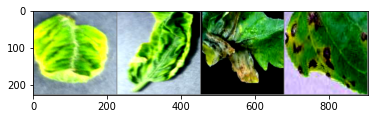

Tomato___Tomato_Yellow_Leaf_Curl_Virus Tomato___Tomato_Yellow_Leaf_Curl_Virus Tomato___Late_blight Tomato___Septoria_leaf_spot


In [5]:
import matplotlib.pyplot as plt
import numpy as np
#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
AlexNet_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(1024,10)
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
import torch.optim as optim
import torch.nn as nn

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

[1,  2000] loss: 0.888
[1,  4000] loss: 0.521
[1,  6000] loss: 0.406
[1,  8000] loss: 0.317
[1, 10000] loss: 0.311
[1, 12000] loss: 0.286
[1, 14000] loss: 0.257
[2,  2000] loss: 0.229
[2,  4000] loss: 0.228
[2,  6000] loss: 0.213
[2,  8000] loss: 0.219
[2, 10000] loss: 0.199
[2, 12000] loss: 0.190
[2, 14000] loss: 0.178
[3,  2000] loss: 0.168
[3,  4000] loss: 0.170
[3,  6000] loss: 0.161
[3,  8000] loss: 0.145
[3, 10000] loss: 0.164
[3, 12000] loss: 0.150
[3, 14000] loss: 0.155
[4,  2000] loss: 0.146
[4,  4000] loss: 0.134
[4,  6000] loss: 0.139
[4,  8000] loss: 0.138
[4, 10000] loss: 0.129
[4, 12000] loss: 0.118
[4, 14000] loss: 0.128
[5,  2000] loss: 0.117
[5,  4000] loss: 0.120
[5,  6000] loss: 0.129
[5,  8000] loss: 0.118
[5, 10000] loss: 0.116
[5, 12000] loss: 0.118
[5, 14000] loss: 0.111
[6,  2000] loss: 0.108
[6,  4000] loss: 0.122
[6,  6000] loss: 0.102
[6,  8000] loss: 0.104
[6, 10000] loss: 0.101
[6, 12000] loss: 0.105
[6, 14000] loss: 0.112
[7,  2000] loss: 0.102
[7,  4000] 

In [10]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [11]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Tomato___Bacterial_spot : 98 %
Accuracy of Tomato___Early_blight : 90 %
Accuracy of Tomato___Late_blight : 93 %
Accuracy of Tomato___Leaf_Mold : 87 %
Accuracy of Tomato___Septoria_leaf_spot : 98 %
Accuracy of Tomato___Spider_mites Two-spotted_spider_mite : 93 %
Accuracy of Tomato___Target_Spot : 95 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 99 %
Accuracy of Tomato___Tomato_mosaic_virus : 94 %
Accuracy of Tomato___healthy : 93 %


In [12]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  94.63044735423708
